In [1]:
import re
from collections import Counter
from tqdm import tqdm
import json
from torch.utils.data import Dataset, DataLoader
import torch

# ConvAI dataset

![convai2-img](http://convai.io/personachat-example.png 'example')



#### How would you solve this problem based on what you have learned till now?

## Raw Data

This is how raw input/target sample from training data of ConvAI dataset looks like:

```
{
    "text": "your persona: i had a gig at local theater last night.\nyour persona: i work as a stand up comedian.\nyour persona: i come from a small town.\nyour persona: my favorite drink is cuba libre.\nyour persona: i did a few small roles in tv series.\nwe all live in a yellow submarine , a yellow submarine . morning !\nhi ! that is a great line for my next stand up .\nlol . i am shy , anything to break the ice , and i am a beatles fan .\ni can tell . i am not , you can see me in some tv shows\nreally ? what shows ? i like tv , it makes me forget i do not like my family\nwow , i wish i had a big family . i grew up in a very small town .\ni did too . i do not get along with mine . they have no class .\njust drink some cola with rum and you'll forget about them !\nput the lime in the coconut as well . . .\nnah , plain cuba libre , that's what we drank yesterday at the theater .\ni prefer mojitos . watermelon or cucumber .",  
    "labels": ["those are really yummy too , but not my favorite ."], 
    "reward": 0, 
    "episode_done": true, 
    "id": "convai2:self:no_cands"
}
```

*  "text" is the input we need = [your persona + dialogue so far]

* "labels" is the output we need = [sentence that model should response]

## Tokenization

Here tokenization is done using a regular expression as in ParlAI framework (where the dataset is coming from!)

In [2]:
RETOK = re.compile(r'\w+|[^\w\s]|\n', re.UNICODE)

In [3]:
# example of parsed text

RETOK.findall('your persona: i had a gig at local theater last night.\nyour persona: i work as a stand up comedian.')

['your',
 'persona',
 ':',
 'i',
 'had',
 'a',
 'gig',
 'at',
 'local',
 'theater',
 'last',
 'night',
 '.',
 '\n',
 'your',
 'persona',
 ':',
 'i',
 'work',
 'as',
 'a',
 'stand',
 'up',
 'comedian',
 '.']

# ConvAI dictionary

The dataset is coming with a precomputed dictionary, it looks like this:

For each word there is a corresponding count. Counts for special symbols are artificially presented / not real.

```
__null__	1000000003
__start__	1000000002
__end__	1000000001
__unk__	1000000000
.	276863
i	270789
you	93655
your	91941
a	89140
?	85346
persona	80372
\n	80365
:	80365
,	79513
to	79240
my	73999
'	68126
do	55199
is	53581
the	49955
```

`ChatDictionary` class implements the loading of that file with helpful functions.

In [4]:
class ChatDictionary(object):
    """
    Simple dict loader
    """
    def __init__(self, dict_file_path):
        self.word2ind = {}  # word:index
        self.ind2word = {}  # index:word
        self.counts = {}  # word:count

        dict_raw = open(dict_file_path, 'r').readlines()
        
        for i, w in enumerate(dict_raw):
            _word, _count = w.strip().split('\t')
            if _word == '\\n':
                _word = '\n'
            self.word2ind[_word] = i
            self.ind2word[i] = _word
            self.counts[_word] = _count
            
    def t2v(self, tokenized_text):
        return [self.word2ind[w] if w in self.counts else self.word2ind['__unk__'] for w in tokenized_text]

    def v2t(self, list_ids):
        return ' '.join([self.ind2word[i] for i in list_ids])
    
    def pred2text(self, tensor):
        result = []
        for i in range(tensor.size(0)):
            if tensor[i].item() == '__end__'  or tensor[i].item() == '__null__':  # null is pad
                break
            else:
                result.append(self.ind2word[tensor[i].item()])
        return ' '.join(result)
    
    def __len__(self):
        return len(self.counts)

# Dataset class

The `ChatDataset` should be familiar to all of you, nothing fancy there

In [5]:
class ChatDataset(Dataset):
    """
    Json dataset wrapper
    """
    
    def __init__(self, dataset_file_path, dictionary, dt='train'):
        super().__init__()
        
        json_text = open(dataset_file_path, 'r').readlines()
        self.samples = []
        
        for sample in tqdm(json_text):
            sample = sample.rstrip()
            sample = json.loads(sample)
            _inp_toked = RETOK.findall(sample['text'])
            _inp_toked_id = dictionary.t2v(_inp_toked)

            sample['text_vec'] = torch.tensor(_inp_toked_id, dtype=torch.long)
            
            # train and valid have different key names for target
            if dt == 'train':
                _tar_toked = RETOK.findall(sample['labels'][0]) + ['__end__']
            elif dt == 'valid':
                _tar_toked = RETOK.findall(sample['eval_labels'][0]) + ['__end__']
                
            _tar_toked_id = dictionary.t2v(_tar_toked)
            
            sample['target_vec'] = torch.tensor(_tar_toked_id, dtype=torch.long)
            
            self.samples.append(sample)
            
    def __getitem__(self, i):
        return self.samples[i]['text_vec'], self.samples[i]['target_vec']
    
    def __len__(self):
        return len(self.samples)

# Padding and batching

`pad_tensor` function implements padding of a given tensor using the specified PAD token.

`batchify` uses both previous function to make a minibatch which is ready to be packed.

In [6]:
def pad_tensor(tensors, sort=True, pad_token=0):
    rows = len(tensors)
    lengths = [len(i) for i in tensors]
    max_t = max(lengths)
        
    output = tensors[0].new(rows, max_t)
    output.fill_(pad_token)  # 0 is a pad token here
    
    for i, (tensor, length) in enumerate(zip(tensors, lengths)):
        output[i,:length] = tensor

    return output, lengths



def batchify(batch):
    inputs = [i[0] for i in batch]
    labels = [i[1] for i in batch]
    
    input_vecs, input_lens = pad_tensor(inputs)
    label_vecs, label_lens = pad_tensor(labels)
    

    return {
        "text_vecs": input_vecs,
        "text_lens": input_lens,
        "target_vecs": label_vecs,
        "target_lens": label_lens,
    }

In [7]:
# loading datasets and dictionary

# downloading pretrained models and data

### DOWNLOADING THE FILES
import os

### persona chat dataset
if not os.path.exists('./dict'):
    !wget "https://nyu.box.com/shared/static/sj9f87tofpicll89xbc154pmbztu5q4h" -O './dict'
if not os.path.exists('./train.jsonl'):
    !wget "https://nyu.box.com/shared/static/aqp0jyjaixjmukm5asasivq2bcfze075.jsonl" -O './train.jsonl'
if not os.path.exists('./valid.jsonl'):
    !wget "https://nyu.box.com/shared/static/eg4ivddtqib2hkf1k8rkxnmzmo0cq27p.jsonl" -O './valid.jsonl'

if not os.path.exists('./chat_model_best_22.pt'):
    !wget "https://nyu.box.com/shared/static/24zsynuks8nzg7530tgakzh8o62id9xa.pt" -O './chat_model_best_22.pt'

chat_dict = ChatDictionary('./dict')
train_dataset = ChatDataset('./train.jsonl', chat_dict)
valid_dataset = ChatDataset('./valid.jsonl', chat_dict, 'valid')

100%|██████████| 7801/7801 [00:01<00:00, 5599.74it/s]


This is how the input to our model looks like now:

In [8]:
train_dataset[0]

(tensor([   7,   10,   12,    5,   21,   14, 3583, 1607,    4,   11,    7,   10,
           12,    5,   21,   14,   56,  655,    4,   11,    7,   10,   12,    5,
           21,   14, 1806,    8, 2105,    4,   11,    7,   10,   12,   15,   44,
         1255,   18,  862,    4,   11,   58,   13,   34,   25,    6,   65,    9,
            5,   16,   26,  245,  430,   14,   17,   97, 6377, 2587,   14,  286,
           24, 1145,    4]),
 tensor([  6, 252,  46,  83, 351,   4, 655,  18,  79,  30,  15,  44, 171,   4,
           2]))

In [9]:
train_loader = DataLoader(train_dataset, shuffle=True, collate_fn=batchify, batch_size=256)
valid_loader = DataLoader(valid_dataset, shuffle=False, collate_fn=batchify, batch_size=256)

# Seq2seq model with attention

![Imgur](https://ikulikov.name/files/seq2seq.png)

In [10]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class EncoderRNN(nn.Module):
    """Encodes the input context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx=0, dropout=0, shared_lt=None):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        self.pad_idx = pad_idx
        
        if shared_lt is None:
            self.embedding = nn.Embedding(self.vocab_size, self.embed_size, pad_idx)
        else:
          # share embedding with decoder
            self.embedding = shared_lt
            
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        
    def forward(self, text_vec, text_lens, hidden=None):
        embedded = self.embedding(text_vec)
        # assign 1 if not equal to pad_idx, otherwisw 0
        attention_mask = text_vec.ne(self.pad_idx)
        embedded = self.dropout(embedded)
        output, hidden = self.gru(embedded, hidden)
        
        return output, hidden, attention_mask

    
class DecoderRNN(nn.Module):
    """Generates a sequence of tokens in response to context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size, 0)
        
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        self.attention = AttentionLayer(self.hidden_size, self.embed_size)

        self.out = nn.Linear(self.hidden_size, self.vocab_size)
        self.longest_label = 100

    def decode_forced(self, ys, encoder_states, xs_lens):
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        batch_size = ys.size(0)
        target_length = ys.size(1)
        longest_label = max(target_length, self.longest_label)
        
        starts = torch.Tensor([1]).long().to(self.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
        
        # Teacher forcing: Feed the target as the next input
        y_in = ys.narrow(1, 0, ys.size(1) - 1)
        decoder_input = torch.cat([starts, y_in], 1)
        decoder_output, decoder_hidden, attn_w_log = self.forward(decoder_input, encoder_hidden, encoder_states)
        _, preds = decoder_output.max(dim=2)
        
        return decoder_output, preds, attn_w_log

    def forward(self, text_vec, decoder_hidden, encoder_states):
        emb = self.embedding(text_vec)
        emb = self.dropout(emb)
        seqlen = text_vec.size(1)
        encoder_output, _, attention_mask = encoder_states
        
        output = []
        attn_w_log = []

        for i in range(seqlen):
            decoder_output, decoder_hidden = self.gru(emb[:,i,:].unsqueeze(1), decoder_hidden)
            
            # compute attention at each time step
            decoder_output_attended, attn_weights = self.attention(decoder_output, decoder_hidden, encoder_output, attention_mask)
            output.append(decoder_output_attended)
            attn_w_log.append(attn_weights)
            
        output = torch.cat(output, dim=1).to(text_vec.device)
        scores = self.out(output)
        
        return scores, decoder_hidden, attn_w_log
    
    
    
    
class AttentionLayer(nn.Module):

    def __init__(self, hidden_size, embedding_size):
        super().__init__()
        input_dim = hidden_size

        self.linear_out = nn.Linear(hidden_size+input_dim, input_dim, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()

    def forward(self, decoder_output, decoder_hidden, encoder_output, attention_mask):

        batch_size, seq_length, hidden_size = encoder_output.size()

        encoder_output_t = encoder_output.transpose(1,2)
        
        attention_scores = torch.bmm(decoder_output, encoder_output_t).squeeze(1)

        attention_scores.masked_fill_((~attention_mask), -10e5)
        attention_weights = self.softmax(attention_scores)

        mix = torch.bmm(attention_weights.unsqueeze(1), encoder_output)

        combined = torch.cat((decoder_output.squeeze(1), mix.squeeze(1)), dim=1)

        output = self.linear_out(combined).unsqueeze(1)
        output = self.tanh(output)

        return output, attention_weights
    
    
class seq2seq(nn.Module):
    """
    Generic seq2seq model with attention mechanism.
    """
    def __init__(self, opts):

        super().__init__()
        self.opts = opts
        
        self.decoder = DecoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_dec'],
                                    dropout=self.opts['dropout'],
                                )
        
        self.encoder = EncoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_enc'],
                                    dropout=self.opts['dropout'],
                                    shared_lt=self.decoder.embedding
        )
        
    def train(self):
        self.encoder.train()
        self.decoder.train()
        
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()

In [11]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

load_pretrained = True
    
if load_pretrained is True:
    if current_device == 'cuda':
        model_pt = torch.load('./chat_model_best_22.pt')
    else:
        model_pt = torch.load('./chat_model_best_22.pt', map_location=torch.device('cpu'))
    opts = model_pt['opts']
    
    model = seq2seq(opts)
    model.load_state_dict(model_pt['state_dict'])
    model.to(current_device)
    
else:
    
    opts = {}

    opts['vocab_size'] = len(chat_dict)
    opts['hidden_size'] = 512
    opts['embedding_size'] = 256
    opts['num_layers_enc'] = 2
    opts['num_layers_dec'] = 2
    opts['dropout'] = 0.3
    opts['encoder_shared_lt'] = True

    model = seq2seq(opts)
    model.to(current_device)

In [12]:
criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), 0.01, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

In [13]:
plot_cache = []

best_val_loss = 100

if not load_pretrained:
    for epoch in range(100):

        model.train()
        sum_loss = 0
        sum_tokens = 0

        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()

            text_vecs = batch['text_vecs'].to('cuda')
            target_vecs = batch['target_vecs'].to('cuda')

            encoded = model.encoder(text_vecs, batch['text_lens'])

            decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])

            scores = decoder_output.view(-1, decoder_output.size(-1))

            loss = criterion(scores, target_vecs.view(-1))
            sum_loss += loss.item()

            num_tokens = target_vecs.ne(0).long().sum().item()
            loss /= num_tokens

            sum_tokens += num_tokens

            loss.backward()
            optimizer.step()

            if i % 100 == 0:
                avg_train_loss = sum_loss/sum_tokens
                print("iter {} train loss = {}".format(i, sum_loss/sum_tokens))

        val_loss = 0
        val_tokens = 0
        for i, batch in enumerate(valid_loader):
            model.eval()

            text_vecs = batch['text_vecs'].to('cuda')
            target_vecs = batch['target_vecs'].to('cuda')

            encoded = model.encoder(text_vecs, batch['text_lens'])

            decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])

            scores = decoder_output.view(-1, decoder_output.size(-1))

            loss = criterion(scores, target_vecs.view(-1))

            num_tokens = target_vecs.ne(0).long().sum().item()

            val_tokens += num_tokens
            val_loss += loss.item()

        avg_val_loss = val_loss/val_tokens
        scheduler.step(avg_val_loss)

        print("Epoch {} valid loss = {}".format(epoch, avg_val_loss))

        plot_cache.append( (avg_train_loss, avg_val_loss) )

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss

            torch.save({
            'state_dict': model.state_dict(),
            'opts': opts,
            'plot_cache': plot_cache,
                }, f'./chat_model_best_{epoch}.pt')

In [14]:
if load_pretrained is True:
    plot_cache = model_pt['plot_cache']

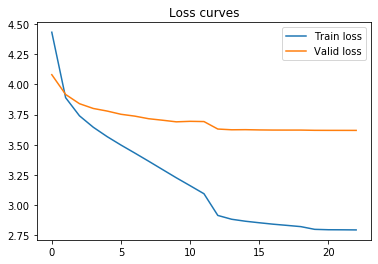

In [15]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [i[0] for i in plot_cache], label='Train loss')
plt.plot(epochs, [i[1] for i in plot_cache], label='Valid loss')

plt.legend()
plt.title('Loss curves')
plt.show()

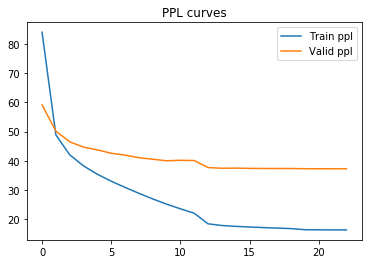

In [16]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/numpy.log(2)) for i in plot_cache], label='Train ppl')
plt.plot(epochs, [2**(i[1]/numpy.log(2)) for i in plot_cache], label='Valid ppl')

plt.legend()
plt.title('PPL curves')
plt.show()

In [17]:
# saving the model, be careful to nor overwrite a good model here
if False:
    torch.save({
        'state_dict': model.state_dict(),
        'opts': opts,
        'plot_cache': plot_cache,
    }, './chat_model.pt')

## Greedy Search

In [18]:
def greedy_search(model, batch, batch_size, max_len=100):
    model.eval()
        
    text_vecs = batch['text_vecs'].to(current_device)

    encoded = model.encoder(text_vecs, batch['text_lens'])
    
    encoder_output, encoder_hidden, attention_mask = encoded
        
    # 1 is __start__
    starts = torch.Tensor([1]).long().to(model.decoder.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
    decoder_hidden = encoder_hidden

    # greedy decoding here        
    preds = [starts]
    scores = []

    # track if each sample in the mini batch is finished
    # if all finished, stop predicting
    finish_mask = torch.Tensor([0]*batch_size).byte().to(model.decoder.embedding.weight.device)
    xs = starts
    _attn_w_log = []

    for ts in range(max_len):
        decoder_output, decoder_hidden, attn_w_log = model.decoder(xs, decoder_hidden, encoded)  # decoder_output: [batch, time, vocab]
        
        _scores, _preds = torch.log_softmax(decoder_output, dim=-1).max(dim=-1)
        
        preds.append(_preds)
        _attn_w_log.append(attn_w_log)
        scores.append(_scores.view(-1)*(finish_mask == 0).float())

        finish_mask += (_preds == 2).byte().view(-1)
        
        if not (torch.any(~finish_mask.bool())):
            break
        
        xs = _preds
    
    preds = torch.cat(preds, dim=-1)
        
    return preds

In [19]:
# artificial example (try removing the question mark, result will be different)
#inputs = RETOK.findall("hello , where are you from?")
inputs = RETOK.findall("your persona: i live in texas.\n hello , where are you ? ?")

test_batch = {
    'text_vecs': torch.tensor([chat_dict.t2v(inputs)], dtype=torch.long, device=model.decoder.embedding.weight.device),
    'text_lens': torch.tensor([len(inputs)], dtype=torch.long)
}

In [20]:
output = greedy_search(model, test_batch, 1)

chat_dict.v2t(output[0].tolist())

'__start__ i am from california , where are you from ? __end__'

### Nucleus Sampling


Reference to the original paper: https://openreview.net/pdf?id=rygGQyrFvH Please read section 3.1 for details. Here we give the needed excerpt:

$$\begin{aligned} P^{\prime}\left(x | x_{1: i-1}\right) &=\left\{\begin{array}{ll}P\left(x | x_{1: i-1}\right) / p^{\prime} & \text { if } x \in V^{\left(p_{\text {nucleus }}\right)} \\ 0 & \text { otherwise }\end{array}\right.\\ p^{\prime} &=\sum_{x \in V^{\left(p_{\text {nucleus }}\right)}} P\left(x | x_{1: i-1}\right) \end{aligned}$$

where $V(p_{nucleus}) ⊂ V$ is a top-p vocabulary which is defined as a smallest subset such that:
$$\sum_{x \in V^{\left(p_{\text {nucleus }}\right)}} P\left(x | x_{1: i-1}\right) \geq p_{\text {nucleus }}$$




In [21]:
# modified from Top-K and Nucleus Sampling from ParlAI
class Nucleus(object):
  def __init__(self,p):
    self.p=p
    
  def select_paths(self, logprobs):
        probs = torch.softmax(logprobs, dim=-1)
        sprobs, sinds = probs.sort(dim=-1, descending=True)
        org=sprobs.clone()
        mask = (sprobs.cumsum(dim=-1) - sprobs[:, :1]) >= self.p
        sprobs[mask] = 0
        sprobs.div_(sprobs.sum(dim=-1).unsqueeze(1))
        choice = torch.multinomial(sprobs[0][0], 1)
        tok_id = sinds[0][0][choice]
        #  back to log
        score = org[0][0][choice].log().detach().data.cpu().numpy()[0]
        return (tok_id, score)

In [22]:
def sampling_with_nucleus(model, batch, batch_size, p, previous_hypo=None, verbose=True, sample=100):
    model.eval()
        
    text_vecs = batch['text_vecs'].to(current_device)
    encoded = model.encoder(text_vecs, batch['text_lens']) 
    encoder_output, encoder_hidden, attention_mask = encoded
        
    all_logpro=[]
    unique_tokens=set()

    for times in range(sample):
      starts = torch.Tensor([1]).long().to(model.decoder.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
      decoder_hidden = encoder_hidden
      preds = []
      scores = []
      xs = starts
      _attn_w_log = []
      for ts in range(50):
          score, decoder_hidden, attn_w_log = model.decoder(xs, decoder_hidden, encoded)  # decoder_output: [batch, time, vocab]
          N = Nucleus(p)
          tok_ids,sc = N.select_paths(score)
          t_tok_ids = tok_ids.data.cpu().numpy()[0]
          preds.append(t_tok_ids)
          unique_tokens.add(t_tok_ids)
          _attn_w_log.append(attn_w_log)
          scores.append(sc)
          eos_token = chat_dict.word2ind['__end__']
          if tok_ids==eos_token:
            break
          xs = torch.Tensor([t_tok_ids]).long().to(model.decoder.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
      all_logpro.append(sum(scores))
      # printing some sample results
      pred_sentence = chat_dict.v2t(preds)
      if verbose:
        print(pred_sentence)
    avg_logpro = sum(all_logpro)/len(all_logpro)
    unique_num = len(unique_tokens)
    return preds, avg_logpro, unique_num, pred_sentence

### Some samples from our sampling method:

In [23]:
valid_loader_single = DataLoader(valid_dataset, shuffle=False, collate_fn=batchify, batch_size=1)
valid_sample = next(iter(valid_loader_single))

In [24]:
print("Input:\n", chat_dict.v2t(valid_sample['text_vecs'][0].tolist()))
print("Target output:\n", chat_dict.v2t(valid_sample['target_vecs'][0].tolist()))

Input:
 your persona : i read twenty books a year . 
 your persona : i ' m a stunt double as my second job . 
 your persona : i only eat __unk__ . 
 your persona : i was raised in a single parent household . 
 hello what are doing today ?
Target output:
 i am good , i just got off work and tired , i have two jobs . __end__


In [25]:
p_values=[0.1,0.5,0.9]
n_samples = 5

p_logprob=[]
p_u_num=[]
for p in p_values:
  print("When p={}, generate {} example decoding sentence:".format(p, n_samples))
  output,res,u_num, _ = sampling_with_nucleus(model, valid_sample, 1, p, sample=n_samples)
  p_logprob.append(round(res,2))
  p_u_num.append(u_num)
  print("\n")

When p=0.1, generate 5 example decoding sentence:
i am doing well . just got done working out . __end__
i am doing well . just got done working out . __end__
i am doing well . just got done working out . __end__
i am doing well . just got done working out . __end__
i am doing well . just got done working out . __end__


When p=0.5, generate 5 example decoding sentence:
hi , i am well . i just got back from the gym . __end__
i ' m good , how are you ? __end__
i ' m doing well . how are you ? __end__
hi , i am a writer . how about you ? __end__
i am doing great . just finished my shift at work . how are you ? __end__


When p=0.9, generate 5 example decoding sentence:
hi , been doing getting ready for work . __end__
hey i am doing pretty good thanks for asking __end__
i ' m fine . i am spending time online . __end__
i am on youtube . i was adopted because i ' m going to work . __end__
i am great . i work at a grocery store . how about you ? __end__




# Beam search

We have learnt what is a beam search. But how to implement it? There are plenty of possible design choices along the way. Here we consider a so called `Beam` class which handles intermediate information.

![beamtree with hyptail](https://ikulikov.name/files/beamtree-example.JPG)

In [26]:
import math
from operator import attrgetter

class _HypothesisTail(object):
    """Hold some bookkeeping about a hypothesis."""

    # use slots because we don't want dynamic attributes here
    __slots__ = ['timestep', 'hypid', 'score', 'tokenid']

    def __init__(self, timestep, hypid, score, tokenid):
        self.timestep = timestep
        self.hypid = hypid
        self.score = score
        self.tokenid = tokenid

class Beam(object):
    """
    This class serves to keep info about partial hypothesis and perform the beam step
    """
    
    def __init__(
        self,
        beam_size,
        padding_token=0,
        bos_token=1,
        eos_token=2,
        min_length=3,
        min_n_best=3,
        device='cpu',
        # for iterbeam below
        similarity_metric='hamming',
        similarity_threshold=0,
    ):
        
        self.beam_size = beam_size
        self.min_length = min_length
        self.eos = eos_token
        self.bos = bos_token
        self.pad = padding_token
        self.device = device
        # recent score for each hypo in the beam
        self.scores = None
        # self.scores values per each time step
        self.all_scores = [torch.Tensor([0.0] * beam_size).to(self.device)]
        # backtracking id to hypothesis at previous time step
        self.bookkeep = []
        # output tokens at each time step
        self.outputs = [
            torch.Tensor(self.beam_size).long().fill_(self.bos).to(self.device)
        ]
        # keeps tuples (score, time_step, hyp_id)
        self.finished = []
        self.eos_top = False
        self.eos_top_ts = None
        self.n_best_counter = 0
        self.min_n_best = min_n_best
        self.partial_hyps = [[self.bos] for i in range(beam_size)]

        # iterbeam related below
        self.history_hyps = []
        self.similarity_metric = similarity_metric
        self.similarity_threshold = similarity_threshold
        self.banned_tokens = set()
        
    def get_output_from_current_step(self):
        """Get the output at the current step."""
        return self.outputs[-1]

    def get_backtrack_from_current_step(self):
        """Get the backtrack at the current step."""
        return self.bookkeep[-1]
    
    ##################### ITER-BEAM BLOCKING PART START #####################
    
    def hamming_distance(self, t1, t2):
        dist = 0
        for tok1, tok2 in zip(t1,t2):
            if tok1 != tok2:
                dist += 1
        return dist
    
    def edit_distance(self, t1, t2):
        import editdistance
        dist = editdistance.eval(t1, t2)
        return dist
                
    def similarity_check(self, active_hyp, previous_hyps, metric='hamming', threshold=0):
        banned_tokens = []
        active_len = len(active_hyp)
        for observed_hyp, _banned_tokens in previous_hyps.items():
            if len(observed_hyp) != active_len:
                continue
            if metric == 'hamming':
                dist = self.hamming_distance(observed_hyp, active_hyp)
            if metric == 'edit':
                dist = self.edit_distance(observed_hyp, active_hyp)
            if dist <= threshold:
                banned_tokens.extend(_banned_tokens)
                    
        return list(set(banned_tokens))
    
    ##################### ITER-BEAM BLOCKING PART END ########################
    
    def select_paths(self, logprobs, prior_scores, previous_hyps):
        """Select the next vocabulary item in these beams."""
        # beam search actually looks over all hypotheses together so we flatten
        beam_scores = logprobs + prior_scores.unsqueeze(1).expand_as(logprobs)
        
        # iterbeam blocking part
        current_length = len(self.all_scores)
        if len(previous_hyps) > 0 and current_length > 0:
            for hyp_id in range(beam_scores.size(0)):
                active_hyp = tuple(self.partial_hyps[hyp_id])
                banned_tokens = self.similarity_check(active_hyp, previous_hyps, metric=self.similarity_metric, threshold=self.similarity_threshold)
                if len(banned_tokens) > 0:
                    beam_scores[:, banned_tokens] = -10e5
            
        flat_beam_scores = beam_scores.view(-1)
        best_scores, best_idxs = torch.topk(flat_beam_scores, self.beam_size, dim=-1)
        voc_size = logprobs.size(-1)

        # get the backtracking hypothesis id as a multiple of full voc_sizes
        hyp_ids = best_idxs / voc_size
        # get the actual word id from residual of the same division
        tok_ids = best_idxs % voc_size
        
        return (hyp_ids, tok_ids, best_scores)
    
    def advance(self, logprobs, previous_hyps):
        """Advance the beam one step."""
        current_length = len(self.all_scores) - 1
        if current_length < self.min_length:
            # penalize all eos probs to make it decode longer
            for hyp_id in range(logprobs.size(0)):
                logprobs[hyp_id][self.eos] = -10e5

        if self.scores is None:
            logprobs = logprobs[0:1]  # we use only the first hyp now, since they are all same
            self.scores = torch.zeros(1).type_as(logprobs).to(logprobs.device)
            
        hyp_ids, tok_ids, self.scores = self.select_paths(logprobs, self.scores, previous_hyps)
        
        # clone scores here to avoid referencing penalized EOS in the future!
        self.all_scores.append(self.scores.clone())

        self.outputs.append(tok_ids)
        self.bookkeep.append(hyp_ids)
        self.partial_hyps = [
            self.partial_hyps[hyp_ids[i]] + [tok_ids[i].item()]
            for i in range(self.beam_size)
        ]
        self.history_hyps.extend(self.partial_hyps)

        #  check new hypos for eos label, if we have some, add to finished
        for hypid in range(self.beam_size):
            if self.outputs[-1][hypid] == self.eos:
                self.scores[hypid] = -10e5
                #  this is finished hypo, adding to finished
                eostail = _HypothesisTail(
                    timestep=len(self.outputs) - 1,
                    hypid=hypid,
                    score=self.all_scores[-1][hypid],
                    tokenid=self.eos,
                )
                self.finished.append(eostail)
                self.n_best_counter += 1

        if self.outputs[-1][0] == self.eos:
            self.eos_top = True
            if self.eos_top_ts is None:
                self.eos_top_ts = len(self.outputs) - 1
    
    def is_done(self):
        """Return whether beam search is complete."""
        return self.eos_top and self.n_best_counter >= self.min_n_best

    def get_top_hyp(self):
        """
        Get single best hypothesis.
        :return: hypothesis sequence and the final score
        """
        return self._get_rescored_finished(n_best=1)[0]

    def _get_hyp_from_finished(self, hypothesis_tail):
        """
        Extract hypothesis ending with EOS at timestep with hyp_id.
        :param timestep:
            timestep with range up to len(self.outputs) - 1
        :param hyp_id:
            id with range up to beam_size - 1
        :return:
            hypothesis sequence
        """
        hyp_idx = []
        endback = hypothesis_tail.hypid
        for i in range(hypothesis_tail.timestep, -1, -1):
            hyp_idx.append(
                _HypothesisTail(
                    timestep=i,
                    hypid=endback,
                    score=self.all_scores[i][endback],
                    tokenid=self.outputs[i][endback],
                )
            )
            endback = self.bookkeep[i - 1][endback]

        return hyp_idx

    def _get_pretty_hypothesis(self, list_of_hypotails):
        """Return hypothesis as a tensor of token ids."""
        return torch.stack([ht.tokenid for ht in reversed(list_of_hypotails)])

    def _get_rescored_finished(self, n_best=None, add_length_penalty=False):
        """
        Return finished hypotheses according to adjusted scores.
        Score adjustment is done according to the Google NMT paper, which
        penalizes long utterances.
        :param n_best:
            number of finalized hypotheses to return
        :return:
            list of (tokens, score) pairs, in sorted order, where:
              - tokens is a tensor of token ids
              - score is the adjusted log probability of the entire utterance
        """
        # if we never actually finished, force one
        if not self.finished:
            self.finished.append(
                _HypothesisTail(
                    timestep=len(self.outputs) - 1,
                    hypid=0,
                    score=self.all_scores[-1][0],
                    tokenid=self.eos,
                )
            )

        rescored_finished = []
        for finished_item in self.finished:
            if add_length_penalty:
                current_length = finished_item.timestep + 1
                # these weights are from Google NMT paper
                length_penalty = math.pow((1 + current_length) / 6, 0.65)
            else:
                length_penalty = 1
            rescored_finished.append(
                _HypothesisTail(
                    timestep=finished_item.timestep,
                    hypid=finished_item.hypid,
                    score=finished_item.score / length_penalty,
                    tokenid=finished_item.tokenid,
                )
            )

        # Note: beam size is almost always pretty small, so sorting is cheap enough
        srted = sorted(rescored_finished, key=attrgetter('score'), reverse=True)

        if n_best is not None:
            srted = srted[:n_best]

        return [
            (self._get_pretty_hypothesis(self._get_hyp_from_finished(hyp)), hyp.score)
            for hyp in srted
        ]

# Model manipulation

As you noticed, after the topk we select the best chosen tails of current hypotheses. And the corresponding previous hypotheses ids can be mixed in order. *We must reorder the hidden buffers of our model. Otherwise, the decoding will be wrong.*

In [27]:
def reorder_encoder_states(encoder_states, indices):
        """Reorder encoder states according to a new set of indices."""
        enc_out, hidden, attention_mask = encoder_states

        # LSTM or GRU/RNN hidden state?
        if isinstance(hidden, torch.Tensor):
            hid, cell = hidden, None
        else:
            hid, cell = hidden

        if not torch.is_tensor(indices):
            # cast indices to a tensor if needed
            indices = torch.LongTensor(indices).to(hid.device)

        hid = hid.index_select(1, indices)
        if cell is None:
            hidden = hid
        else:
            cell = cell.index_select(1, indices)
            hidden = (hid, cell)

        enc_out = enc_out.index_select(0, indices)
        attention_mask = attention_mask.index_select(0, indices)

        return enc_out, hidden, attention_mask
    
    
def reorder_decoder_incremental_state(incremental_state, inds):
    if torch.is_tensor(incremental_state):
        # gru or lstm
        return torch.index_select(incremental_state, 1, inds).contiguous()
    elif isinstance(incremental_state, tuple):
        return tuple(
            self.reorder_decoder_incremental_state(x, inds)
            for x in incremental_state)

def get_nbest_list_from_beam(beam, dictionary, n_best=None, add_length_penalty=False):
    if n_best is None:
        n_best = beam.min_n_best
    nbest_list = beam._get_rescored_finished(n_best=n_best, add_length_penalty=add_length_penalty)
    
    nbest_list_text = [(dictionary.v2t(i[0].cpu().tolist()), i[1].item()) for i in nbest_list]
    
    return nbest_list_text

In [28]:
def generate_with_beam(beam_size, min_n_best, model, batch, batch_size, 
                       previous_hyps=None, similarity_metric='hamming', 
                       similarity_threshold=0, verbose=False):
    """
    This function takes a model, batch, beam settings and performs decoding with a beam. PRe beams_best_pick
    """
    beams = [   Beam(beam_size, 
                     min_n_best=min_n_best, 
                     eos_token=chat_dict.word2ind['__end__'], 
                     padding_token=chat_dict.word2ind['__null__'], 
                     bos_token=chat_dict.word2ind['__start__'], 
                     device=current_device, 
                     similarity_metric=similarity_metric, 
                     similarity_threshold=similarity_threshold) for _ in range(batch_size)]
    
    repeated_inds = torch.arange(batch_size).to(current_device).unsqueeze(1).repeat(1, beam_size).view(-1)
    
    text_vecs = batch['text_vecs'].to(current_device)

    encoder_states = model.encoder(text_vecs, batch['text_lens'])
    
    model.eval()
    
    encoder_states = reorder_encoder_states(encoder_states, repeated_inds)  # no actual reordering here, but repeating beam size times each sample in the minibatch
    encoder_output, encoder_hidden, attention_mask = encoder_states
    
    incr_state = encoder_hidden  # we init decoder hidden with last encoder_hidden
    
    # 1 is a start token id
    starts = torch.Tensor([1]).long().to(model.decoder.embedding.weight.device).expand(batch_size*beam_size, 1).long()  # expand to batch_size * beam_size
    decoder_input = starts
    
    with torch.no_grad():
        for ts in range(100):
            if all((b.is_done() for b in beams)):
                break
            score, incr_state, attn_w_log = model.decoder(decoder_input, incr_state, encoder_states)
            score = score[:, -1:, :]  # take last time step and eliminate the dimension
            score = score.view(batch_size, beam_size, -1)
            score = torch.log_softmax(score, dim=-1)
         
            for i, b in enumerate(beams):
                if not b.is_done():
                    # make mock previous_hyps if not used #
                    if previous_hyps is None:
                        previous_hyps = [{} for i in range(batch_size)]

                    b.advance(score[i], previous_hyps[i])

            incr_state_inds = torch.cat([beam_size * i + b.get_backtrack_from_current_step() for i, b in enumerate(beams)])
            incr_state = reorder_decoder_incremental_state(incr_state, incr_state_inds)
            selection = torch.cat([b.get_output_from_current_step() for b in beams]).unsqueeze(-1)
            decoder_input = selection

    beam_preds_scores = [list(b.get_top_hyp()) for b in beams]
    beams_best_pick = get_nbest_list_from_beam(beams[0], chat_dict, n_best=1)[0][0]

    if verbose:
        for bi in range(batch_size):
            print(f'batch {bi}')
            for i in get_nbest_list_from_beam(beams[bi], chat_dict, n_best=min_n_best):
                print(i)
    
    return beam_preds_scores, beams, beams_best_pick

# Generating some predictions

In [29]:
batch_size = 1
beam_size = 5
beam_n_best = 5 #return top beam_n_best outputs

valid_loader_single = DataLoader(valid_dataset, shuffle=False, collate_fn=batchify, batch_size=batch_size)

valid_sample = next(iter(valid_loader_single))

beam_preds_scores, beams, _ = generate_with_beam(beam_size, 
                                                 beam_n_best, 
                                                 model, 
                                                 valid_sample, 
                                                 batch_size=batch_size, 
                                                 verbose=True)

batch 0
("__start__ i ' m doing well , how are you ? __end__", -8.027989387512207)
("__start__ i ' m doing great . how are you ? __end__", -8.215302467346191)
("__start__ i ' m doing well . how are you ? __end__", -8.261406898498535)
("__start__ i ' m doing well , how about yourself ? __end__", -8.271869659423828)
("__start__ i ' m doing well , how about you ? __end__", -8.544331550598145)


## Hm, why they are so similar? Lets make a visualization tool

Run this from your terminal (if you haven't installed already)

sudo apt install libgraphviz-dev

In [30]:

!pip install --install-option="--include-path=/usr/local/include/graphviz/" --install-option="--library-path=/usr/local/lib/graphviz" pygraphviz

/opt/anaconda3/lib/python3.7/site-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
     |████████████████████████████████| 122kB 7.3MB/s eta 0:00:01
Skipping wheel build for pygraphviz, due to binaries being disabled for it.
    Running setup.py install for pygraphviz ... done


In [31]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

def get_beam_dot(beam: Beam, plot_size=30):
        """Create pydot graph representation of the beam.
        """

        graph = nx.DiGraph()
        outputs = numpy.array([i.tolist() for i in beams[0].outputs])
        bookkeep = numpy.array([i.tolist() for i in beams[0].bookkeep])
        all_scores = numpy.array([i.tolist() for i in beams[0].all_scores])
        
        max_ts = outputs.shape[0]
        
        labels_dict = {}
        node_color_map = []

        for i in range(max_ts):
            if i == 0:
                # only one start
                start_node = f"t_{0}__hid_{0}__tok_{outputs[i][0]}__sc_{all_scores[i][0]}"
                #start_node = {"time":0, "hypid": 0, "token": outputs[i][0], "score": all_scores[i][0]}
                graph.add_node(start_node)
                labels_dict[start_node] = chat_dict.ind2word[outputs[i][0]]
                node_color_map.append('aliceblue')
                continue

            for hypid, token in enumerate(outputs[i]): # go over each token on this level
                backtrack_hypid = bookkeep[i-1][hypid]
                backtracked_node = f"t_{i-1}__hid_{backtrack_hypid}__tok_{outputs[i-1][backtrack_hypid]}__sc_{all_scores[i-1][backtrack_hypid]}"
                current_score = all_scores[i][hypid]
                node = f"t_{i}__hid_{hypid}__tok_{token}__sc_{current_score}"
                graph.add_node(node)
                graph.add_edge(backtracked_node, node)

                if token == 2:
                    node_color_map.append('pink')
                    labels_dict[node] = "__end__\n{:.{prec}f}".format(current_score, prec=4)
                else:
                    node_color_map.append('aliceblue')
                    labels_dict[node] = chat_dict.ind2word[token]

        # same layout using matplotlib with no labels
        plt.figure(figsize=(plot_size,plot_size))
        plt.title('Beam tree')
        pos =graphviz_layout(graph, prog='dot')
        nx.draw(graph, pos, labels=labels_dict, with_labels=True, arrows=True, font_size=24, node_size=5000, font_color='black', alpha=1.0, node_color=node_color_map)
        plt.show()

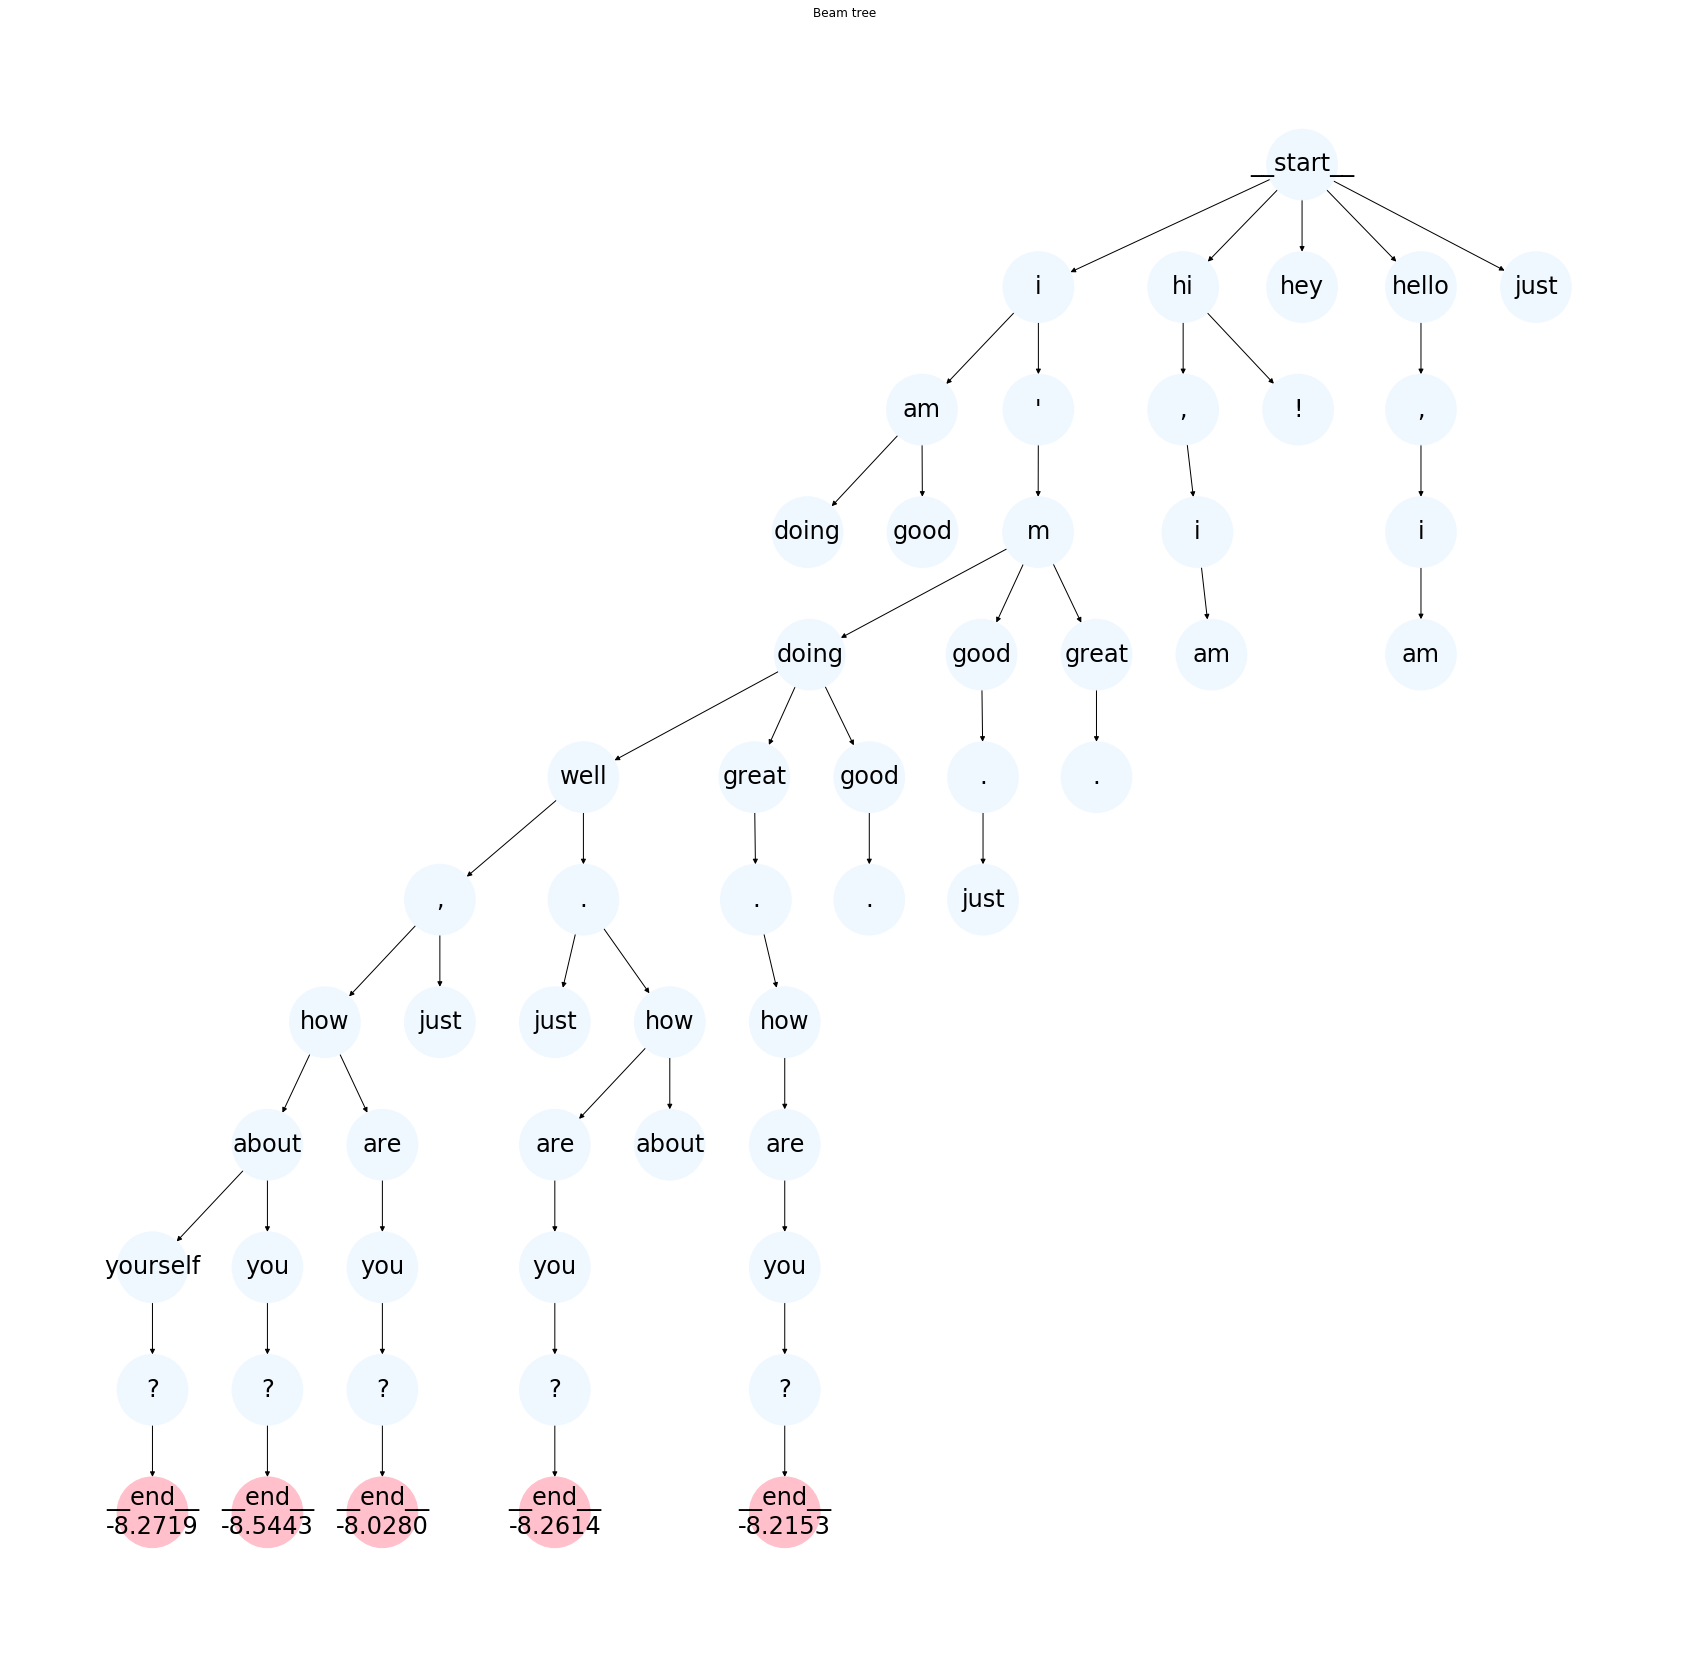

In [32]:
get_beam_dot(beams[0])

In [33]:
# lets try bigger beam size

batch_size = 1
beam_size = 20
beam_n_best = 20

# shuffling to make different examples
valid_loader_single = DataLoader(valid_dataset, shuffle=True, collate_fn=batchify, batch_size=batch_size)

valid_sample = next(iter(valid_loader_single))

print(f"Input : {chat_dict.v2t(valid_sample['text_vecs'][0].tolist())}\n")

beam_preds_scores, beams, _ = generate_with_beam(beam_size, beam_n_best, model, valid_sample, batch_size=batch_size, verbose=True)

Input : your persona : i am a buddhist . 
 your persona : i quit my job to pursue my spirituality full time . 
 your persona : i haven ' t spoken in three months . 
 your persona : i like meditation . 
 your persona : i live in alaska . 
 hi , how are you doing today ?

batch 0
('__start__ i am good how are you __end__', -5.433663368225098)
("__start__ i ' m good how are you __end__", -5.7742414474487305)
('__start__ i am great , how are you ? __end__', -6.031922340393066)
('__start__ i am good how are you ? __end__', -6.2020416259765625)
("__start__ i ' m good how are you ? __end__", -6.4818572998046875)
("__start__ i ' m great , how are you ? __end__", -6.541374206542969)
("__start__ i ' m doing well , how are you ? __end__", -6.561040878295898)
("__start__ i ' m good . how are you ? __end__", -6.567502975463867)
('__start__ i am doing well , how are you ? __end__', -6.7365922927856445)
("__start__ i ' m great . how are you ? __end__", -6.737302780151367)
("__start__ i ' m doing grea

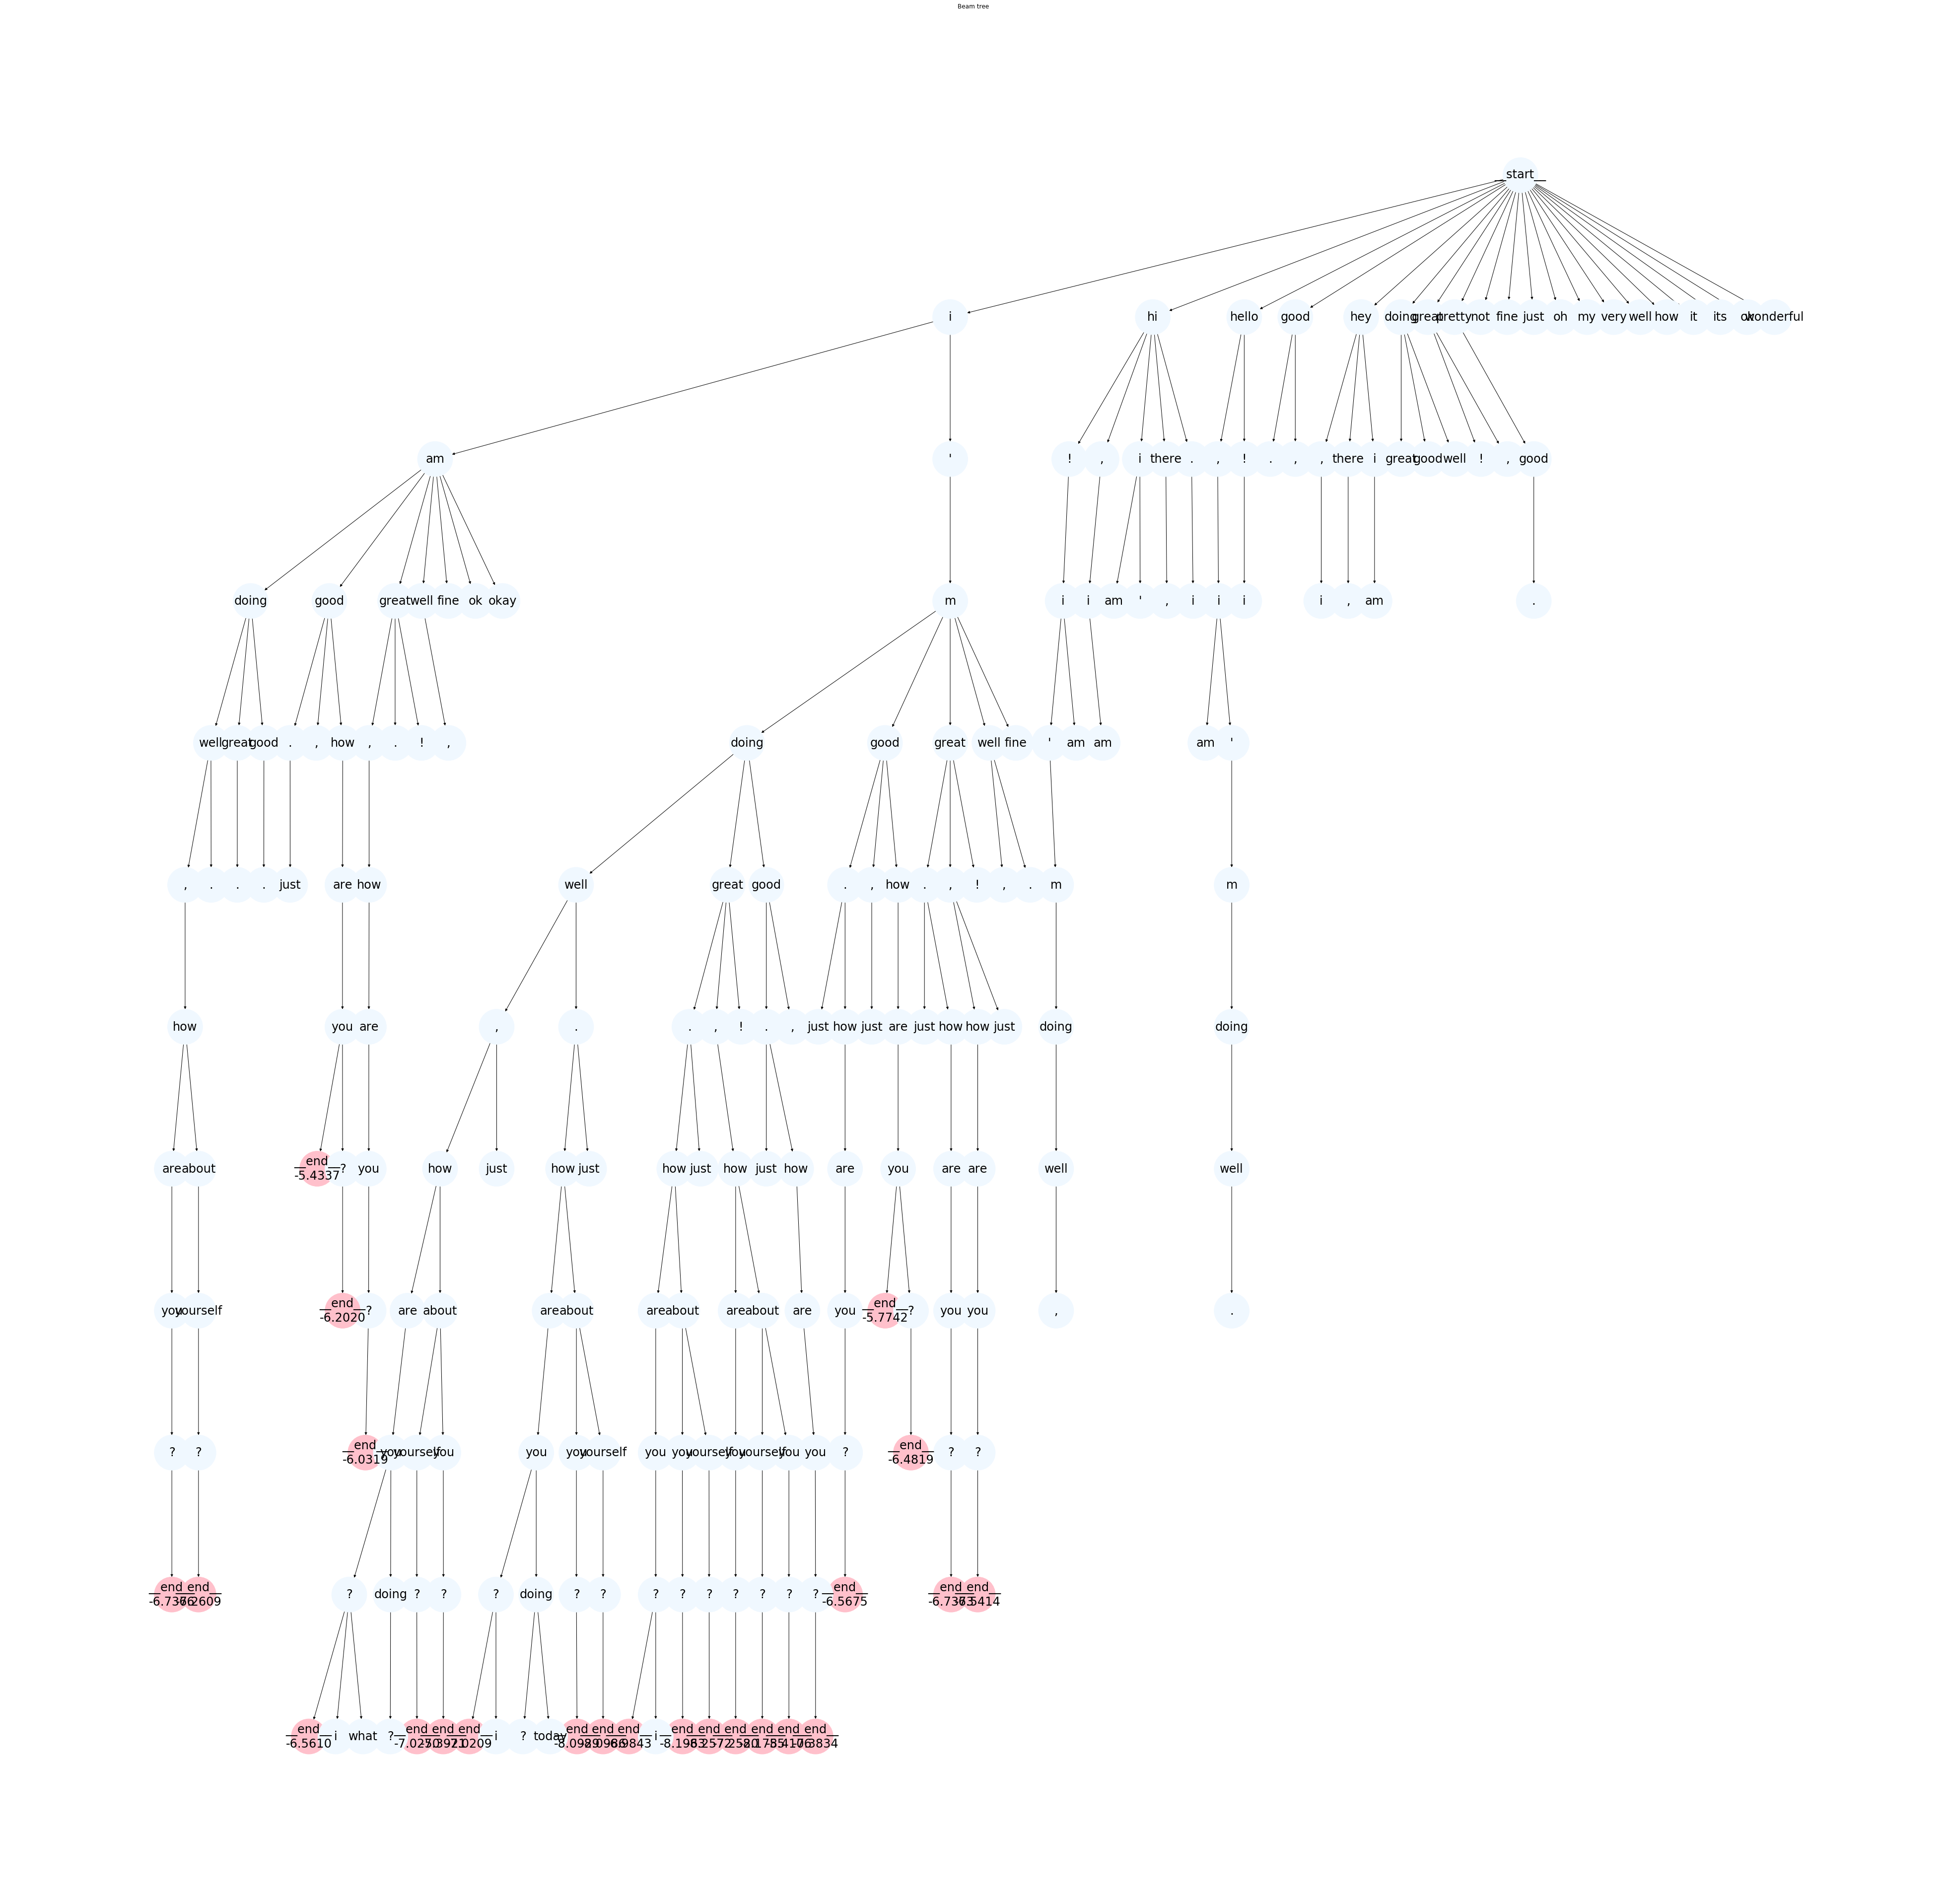

In [34]:
get_beam_dot(beams[0], 70)

# To be explored by the students on their own:

### Iterative beam search: do not explore tokens you have already seen in the previous iteration

There many strategies which work in a similar way: diverse beam search, RL-based rescoring of beam hypotheses, iterative beam search.
Here we keep it simple: on each iteration we keep currently observed search space and block observed hypotheses tails of similar hypotheses in the following iterations.

There can be many ways of how we qualify a hypothesis to be similar to other one. Here we define a similarity metric e.g. `edit distance` and a minimum threshold it should surpass to be a *different* one.

def fill_prefixes(prefix_dict, history_hyps):
    for hyp in history_hyps:
        for j in range(len(hyp)):
            _prefix = tuple(hyp[:j])
            if _prefix in prefix_dict:
                if hyp[j] in prefix_dict[_prefix]:
                    continue
                else:
                    prefix_dict[_prefix].append(hyp[j])
            else:
                prefix_dict[_prefix] = [hyp[j]]

def iterative_beam(num_iterations, beam_size, n_best_beam, model, batch, batch_size=1, similarity_metric='hamming', similarity_threshold=0, verbose=True):
    
    prefix_dict = [{} for i in range(batch_size)]
    outputs = []
    
    for beam_iter in range(num_iterations):
        beam_preds_scores, beams, _ = generate_with_beam(beam_size, n_best_beam, model, batch, batch_size=batch_size, previous_hyps=prefix_dict, similarity_metric=similarity_metric, similarity_threshold=similarity_threshold)
        
        
        
        outputs.append((beam_preds_scores, beams))
        
        for i, _dict in enumerate(prefix_dict):
            fill_prefixes(_dict, beams[i].history_hyps)
        
    
    if verbose:
        for bi in range(batch_size):
            for i in range(num_iterations):
                print(f'Iter  {i}')
                for j in get_nbest_list_from_beam(outputs[i][1][bi], chat_dict, n_best_beam):
                    print(j)
            
    return outputs, prefix_dict

batch_size = 1
iter_beam_size = 2
beam_n_best = 2
beam_iter = 10

print(f"Input : {chat_dict.v2t(valid_sample['text_vecs'][0].tolist())}\n")

outputs, prefix_dict = iterative_beam(beam_iter, iter_beam_size, beam_n_best, model, valid_sample, batch_size=batch_size, similarity_metric='edit', similarity_threshold=3, verbose=True)

print('\n\n\n')

batch_size = 1
iter_beam_size = 5
beam_n_best = 5
beam_iter = 4

outputs, prefix_dict = iterative_beam(beam_iter, iter_beam_size, beam_n_best, model, valid_sample, batch_size=batch_size, similarity_metric='edit', similarity_threshold=5, verbose=True)

## Interactive Chatbot

In [35]:
# REFERENCE:https://pytorch.org/tutorials/beginner/chatbot_tutorial.html#run-evaluation
import unicodedata
import re

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
  '''
  convert all letters to lowercase and trim all non-letter characters except for basic punctuation (normalizeString)
  '''
  s = unicodeToAscii(s.lower().strip())
  s = re.sub(r"([.!?])", r" \1", s)
  s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
  s = re.sub(r"\s+", r" ", s).strip()
  return s

def tokenHistory(history,input_sentence):
  # add the input sentence to all previous history
  history += ' \n '+input_sentence
  # parse input history
  _inp_toked = RETOK.findall(history)
  _inp_toked_id = chat_dict.t2v(_inp_toked)
  input_vecs = torch.tensor([_inp_toked_id], dtype=torch.long)
  length_input = torch.tensor([len(input_vecs[0])], dtype=torch.int64)
  token_history ={'text_vecs': input_vecs, 'text_lens': length_input}
  return history, token_history

def ChatBot(model, persona, beam_size=5, prob_ns=0.5, decode_method="Beam"):
    assert( decode_method in ['Beam', 'NS', 'Greedy'])
    history = persona # should be initialize with persona "words" string

    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            while not input_sentence:
                print('Prompt should not be empty!')
                
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            
            # add the input sentence to all previous history
            history += ' \n '+input_sentence

            # parse input history
            _inp_toked = RETOK.findall(history)
            _inp_toked_id = chat_dict.t2v(_inp_toked)
            input_vecs = torch.tensor([_inp_toked_id], dtype=torch.long)
            length_input = torch.tensor([len(input_vecs[0])], dtype=torch.int64)
            batch_history ={'text_vecs': input_vecs, 'text_lens': length_input}


            # Evaluate sentence
            if decode_method=="Beam":
              _, _, output_words = generate_with_beam(beam_size, beam_n_best, model, batch_history, batch_size=1, verbose=False)
            elif decode_method=="NS": 
              _, _, _, output_words = sampling_with_nucleus(model, batch_history, 1, prob_ns, previous_hypo=None, verbose=None, sample=1)
            elif decode_method=="Greedy": 
              output = greedy_search(model, batch_history, 1, max_len = 50)
              output_words = chat_dict.v2t(output[0].tolist())
            # add bot output to history
            history += '\n'+output_words

            # Format and print response sentence
            print('Bot:'+output_words.replace('__start__','').replace('__end__',''))
            

        except KeyError:
            print("Error: Encountered unknown word.")





### Interactions:

In [36]:
# input "q" or "quit" to quit the interactive session.

In [37]:
persona1 = "your persona : i love to drink wine and dance in the moonlight . \n your persona : i am very strong for my age . \n your persona : i ' m 100 years old . \n your persona : i feel like i might live forever ."
print(persona1)

your persona : i love to drink wine and dance in the moonlight . 
 your persona : i am very strong for my age . 
 your persona : i ' m 100 years old . 
 your persona : i feel like i might live forever .


In [38]:
ChatBot(model, persona1, decode_method='Greedy')

>  how are you 


Bot: i am good . how are you ? 


>  Am great, whats up with you today?


Bot: i ' m going to be a lawyer 


>  thats great, what did you eat?


Bot: i ' m a vegetarian . i ' m a vegetarian 


>  oh do you like pets?


Bot: i do not . i ' m a big fan of elvis 


>  who is elvis


Bot: i love to fish and eat fish 


>  you are speaking gibberish


Bot: i am not sure . i ' m not sure what i want to do . 


>  ok bye


Bot: i ' m sure you are right . 


>  q


In [39]:
ChatBot(model, persona1, prob_ns = 0.3, decode_method='NS')

>  hi there


Bot:hello , how are you today ? 


>  am great, how are you too?


Bot:i am doing well , how are you ? 


>  wonderful


Bot:i am doing well , thanks . what do you do for a living ? 


>  am a student


Bot:i ' m a graphic designer , i ' m a banker 


>  you have two jobs?


Bot:i ' ve a big family 


>  good for you 


Bot:i am in the city . what do you do for work ? 


>  i am a student


Bot:i am a teacher . i ' m a farmer 


>  ok see you later


Bot:i am in school . i live in a dorm 


>  bye


Bot:yeah i ' m a teacher . 


>  q


In [40]:
ChatBot(model, persona1, beam_size=5, decode_method='Beam')

>  hi there


Bot: hello , how are you today ? 


>  am great


Bot: what do you do for a living ? 


>  am a student


Bot: what do you do for a living ? 


>  am a student and how about you ?


Bot: i ' m in school right now 


>  sure, then see you later


Bot: what do you do for a living ? 


>  i have to go


Bot: what city are you from ? 


>  bye


Bot: what do you do for a living ? 


>  q


In [41]:
ChatBot(model, persona1, beam_size = 8, decode_method='Beam')

>  hi there how are you 


Bot: i ' m good how are you 


>  am great


Bot: what do you do for a living ? 


>  am a student


Bot: what city are you from ? 


>  Kigali


Bot: what city are you from ? 


>  am from Kigali and where are you from?


Bot: i am from cali 


>  I love California, how is the weather in Cali?


Bot: i live in california 


>  I know


Bot: what city are you from ? 


>  I told you earlier


Bot: what city are you from ? 


>  I have to go 


Bot: what city are you from ? 


>  bye


Bot: what city are you from ? 


>  q


## ChatBot Comparing All Decoding Method

In [42]:
def ChatBotAll(model, persona, beam_size=5, prob_ns=0.5):
  # three different history for all three decoding methods
    history_beam, history_ns, history_greedy  = persona, persona, persona # initialize with persona "words" string
    history_list = [history_beam, history_ns, history_greedy]
  
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            while not input_sentence:
                print('Prompt should not be empty!')
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)

            # Evaluate sentence
            # "Beam":
            history_beam, token_history = tokenHistory(history_beam,input_sentence)
            _, _, output_words = generate_with_beam(beam_size, beam_n_best, model, token_history, batch_size=1, verbose=False)
            # Format and print response sentence
            print('Beam Bot:'+output_words.replace('__start__','').replace('__end__',''))
            # add bot output to history
            history_beam += '\n'+output_words
            # "NS":
            history_ns, token_history = tokenHistory(history_ns,input_sentence)
            _, _, _, output_words = sampling_with_nucleus(model, token_history, 1, prob_ns, previous_hypo=None, verbose=None, sample=1)
            print('NS Bot:'+output_words.replace('__start__','').replace('__end__',''))
            history_ns += '\n'+output_words
            # "greedy": 
            history_greedy, token_history = tokenHistory(history_greedy,input_sentence)
            output = greedy_search(model, token_history, 1, max_len=100)
            output_words = chat_dict.v2t(output[0].tolist())
            print('Greedy Bot:'+output_words.replace('__start__','').replace('__end__',''))
            history_greedy += '\n'+output_words
        
        except KeyError:
            print("Error: Encountered unknown word.")

In [43]:
persona2 = "your persona : i love disneyland and mickey mouse . \n your persona : i love to spend time with my family . \n your persona : i ' m a baby delivery nurse . \n your persona : i walk three miles every day ."
print(persona2)

your persona : i love disneyland and mickey mouse . 
 your persona : i love to spend time with my family . 
 your persona : i ' m a baby delivery nurse . 
 your persona : i walk three miles every day .


In [44]:
ChatBotAll(model, persona2, beam_size = 15, prob_ns=0.3)

>  hi 


Beam Bot: hello , how are you today ? 
NS Bot:hello , how are you today ? 
Greedy Bot: hello , how are you today ? 


>  am great


Beam Bot: what do you do for a living ? 
NS Bot:what do you do for a living ? 
Greedy Bot: i ' m doing great , just got back from a run . 


>  I love running too 


Beam Bot: what do you do for a living ? 
NS Bot:i love to run , do you ? 
Greedy Bot: i love to read , especially when i am not working at the gym 


>  thats wonderful


Beam Bot: what city are you from ? 
NS Bot:do you have any hobbies ? 
Greedy Bot: i love to read , especially when i am not working at home 


>  i have to go


Beam Bot: do you have any hobbies ? 
NS Bot:i like to go to the gym 
Greedy Bot: i work in a publishing shop , i love to read 


>  ok


Beam Bot: what do you do for a living ? 
NS Bot:i love to go to the movies 
Greedy Bot: i ' m a librarian , i ' m a veterinarian 


>  q


In [45]:
ChatBotAll(model, persona2, beam_size=5, prob_ns=0.3)

>  hello 


Beam Bot: hi how are you today 
NS Bot:hello , how are you today ? 
Greedy Bot: hello , how are you today ? 


>  am great


Beam Bot: what do you do for a living ? 
NS Bot:i ' m doing great , just finished working at the animal shelter . 
Greedy Bot: i ' m doing great , just got back from a run . 


>  sure


Beam Bot: what do you do for a living ? 
NS Bot:i am a stay at home mom 
Greedy Bot: i ' m a librarian , i work in a clothing store . 


>  sure


Beam Bot: what city are you from ? 
NS Bot:yes , i ' m a stay at home mom 
Greedy Bot: i ' m a vet , i work in a clothing store . 


>  ok


Beam Bot: what city are you from ? 
NS Bot:yeah , i love the mountains 
Greedy Bot: i ' m a vet , i ' m a veterinarian 


>  i have to go


Beam Bot: do you have any hobbies ? 
NS Bot:i work at a clothing store 
Greedy Bot: i ' m a programmer , i ' m a veterinarian 


>  byw


Beam Bot: what do you do for a living 
NS Bot:i am a very good mother 
Greedy Bot: i ' m a programmer , i ' m a tutor 


>  bye


Beam Bot: what city are you from ? 
NS Bot:i love to go to the movies 
Greedy Bot: i ' m a little weird , i ' m a physical therapist 


>  q


In [46]:
persona3 = "your persona : i love to drink fancy tea . \n your persona : i have a big library at home . \n your persona : i ' m a museum tour guide . \n your persona : i ' m partly deaf ."
print(persona3)

your persona : i love to drink fancy tea . 
 your persona : i have a big library at home . 
 your persona : i ' m a museum tour guide . 
 your persona : i ' m partly deaf .


In [47]:
ChatBotAll(model, persona3, beam_size=5, prob_ns=0.3)

>  hi 


Beam Bot: hi how are you today 
NS Bot:hello , how are you today ? 
Greedy Bot: hello , how are you today ? 


>  am great


Beam Bot: what do you do for a living ? 
NS Bot:what do you do for a living ? 
Greedy Bot: i ' m doing great , just got done eating some shrimp . 


>  sure


Beam Bot: what city are you from ? 
NS Bot:what do you do for a living ? 
Greedy Bot: i ' m a huge fan of pasta , i love it . 


>  ok


Beam Bot: what do you do for a living 
NS Bot:what do you do for a living ? 
Greedy Bot: i ' m not sure . i do not have time for that 


>  i know


Beam Bot: what city are you from ? 
NS Bot:i see . i am a programmer 
Greedy Bot: i ' m a bit of a loner 


>  me too


Beam Bot: what city are you from ? 
NS Bot:what do you do for a living ? 
Greedy Bot: i ' m sorry to hear that . i ' m a slacker 


>  am sorry


Beam Bot: what do you do for a living 
NS Bot:i am a student . i do not have time for anything 
Greedy Bot: i ' m a bit of a loner 


>  Coronavirus is keeping me indoors for weeks now


Beam Bot: what do you do for a living ? 
NS Bot:what do you do for a living ? 
Greedy Bot: i like to go shopping 


>  yes maybe when its safe to go out


Beam Bot: what city are you from ? 
NS Bot:that is cool . i like to go to the park 
Greedy Bot: i ' m not sure . i ' m not very good at it 


>  ok


Beam Bot: do you have any hobbies ? 
NS Bot:i ' m not sure . i ' m a bit of a loner 
Greedy Bot: i ' m not sure what that is 


>  me too


Beam Bot: what do you do for a living ? 
NS Bot:what do you do for a living ? 
Greedy Bot: i ' m sorry to hear that 


>  i have to go


Beam Bot: do you have any hobbies ? 
NS Bot:what do you do for a living ? 
Greedy Bot: i ' m sorry to hear that . 


>  bye


Beam Bot: do you like to travel 
NS Bot:what do you do for a living ? 
Greedy Bot: i ' m not sure . i ' m not sure what i want to do 


>  q


In [48]:
persona4 = "your persona : i study machine learning . \n your persona : i live in kigali . \n your persona : i ' m very smart . \n your persona : i love nlp ."
print(persona3)

your persona : i love to drink fancy tea . 
 your persona : i have a big library at home . 
 your persona : i ' m a museum tour guide . 
 your persona : i ' m partly deaf .


In [49]:
persona4

"your persona : i study machine learning . \n your persona : i live in kigali . \n your persona : i ' m very smart . \n your persona : i love nlp ."

In [50]:
ChatBotAll(model, persona4, beam_size=3, prob_ns=0.3)

>  hello


Beam Bot: hi how are you today 
NS Bot:hello , how are you today ? 
Greedy Bot: hello , how are you today ? 


>  am great


Beam Bot: what do you do for a living ? 
NS Bot:i ' m doing great , thanks for asking . 
Greedy Bot: i ' m doing great , just got back from a hike 


>  ok


Beam Bot: what city are you from ? 
NS Bot:what do you do for a living ? 
Greedy Bot: i ' m a huge fan of anime 


>  ok good to know


Beam Bot: what do you do for a living 
NS Bot:i ' m a scientist , i love to go to the beach 
Greedy Bot: i ' m not sure if i ' m not working , i ' m a male 


>  alright


Beam Bot: what do you do for a living 
NS Bot:i ' m not sure what that is . 
Greedy Bot: i ' m not sure what i want to do 


>  i have to go


Beam Bot: that ' s cool do you have any hobbies 
NS Bot:i love to go to the lake 
Greedy Bot: i ' m sorry to hear that . i ' m sorry to hear that 


>  talk later


Beam Bot: do you have any hobbies ? 
NS Bot:i live in portland , where do you live ? 
Greedy Bot: i ' m sorry to hear that . i ' m sorry 


>  bye


Beam Bot: do you like to travel ? 
NS Bot:i live in california , where are you from ? 
Greedy Bot: i ' m sorry to hear that . i ' m sorry 


>  q
